In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from collections import defaultdict
import seaborn as sns
sns.set_theme(palette="colorblind")
sns.set_style("white", {'axes.grid': False})

t = 1.5

SMALL_SIZE = 10 * t
MEDIUM_SIZE = 12 * t
BIGGER_SIZE = 14 * t

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [ ]:
import os

# folder = "real-world"
folder = "generated"
violin = folder + "/violin"
tables = folder + "/tables"

os.makedirs(folder, exist_ok=True)
os.makedirs(violin, exist_ok=True)
os.makedirs(tables, exist_ok=True)

In [ ]:
from evaluation.statistic_testing.basics import basic_configs
from evaluation.statistic_testing.basics import basic_metrics
from evaluation.statistic_testing.basics import basic_models
from evaluation.statistic_testing.basics import basic_obs, basic_rews
from src.data import get_data, get_gmm, get_pv_data
from src.pv.pv import read_pv_data
from src.observations import minute_observation_stay
from src.pv.metrics import *
from gymportal.evaluation import *
from src.pv.rewards import *
from src.pv.observations import pv_observation_mean
from gymportal.environment import *
from src.pv.pv import read_pv_data
import pytz
from datetime import datetime, timedelta
from gymportal.sim import get_charging_network, Recomputer, EvaluationSimulator, SimGenerator
from gymportal.data.battery_generators import CustomizableBatteryGenerator
from acnportal.acnsim import Linear2StageBattery
from src.rewards import sparse_soc_reward
from src.utils import AV_pod_ids, get_generator, get_power_function
from gymportal.data.ev_generators import get_standard_generator, RealWorldGenerator

timezone = pytz.timezone("America/Los_Angeles")


charging_network = get_charging_network(
    'simple_acn',
    basic_evse=True,
    voltage=208,
    network_kwargs={
        'station_ids': AV_pod_ids,
        "aggregate_cap": (150 / 54) * len(AV_pod_ids),
    },
)

# charging_network = get_charging_network('caltech', basic_evse=True, voltage=208,
#                                         network_kwargs={"transformer_cap": 150})

battery_generator = CustomizableBatteryGenerator(
    voltage=208,
    period=1,
    battery_types=[
        Linear2StageBattery,
    ],
    max_power_function=get_power_function,
)

# ev_generator = RealWorldGenerator(
#    battery_generator=battery_generator, site='caltech', period=1)
ev_generator = get_generator(
    'caltech',
    get_gmm(), # TODO Use other GMM for out-of-distrbution
    battery_generator,
    seed=4645643, #42
    frequency_multiplicator=10, #10
    duration_multiplicator=1, #2
    data=get_data(),
)

df_pv = get_pv_data()
df_pv.describe()
df_pv.P /= 54 / len(charging_network.station_ids)

observation_objects = basic_obs(df_pv)
reward_objects = basic_rews(df_pv)


metrics = basic_metrics(df_pv)


configs = basic_configs(
    observation_objects=observation_objects,
    reward_objects=reward_objects,
    action=zero_centered_single_charging_schedule_normalized(),
    # timezone=timezone,
    charging_network=charging_network,
    ev_generator=ev_generator,
    start_date = datetime(2019, 1, 1, tzinfo=timezone),
)

configs

In [ ]:
models = basic_models(configs)

In [ ]:
from src.actions import beta_one_for_all_schedule, beta_schedule_normalized
from src.utils import evaluate_model
from src.cleanRL.environment import make_env

__tuples = {}
for model_name, model in models.items():

    if isinstance(model, ACNSchedule):
        action = single_charging_schedule()
    elif model_name in ["BCC", "BSC", "B-BC", "BSC+BC"]:
        # ic(model_name)
        action = beta_schedule_normalized()
    elif model_name == "BSO":
        # ic(model_name)
        action = beta_one_for_all_schedule()
    else:
        action = zero_centered_single_charging_schedule_normalized()

    __tuples[model_name] = [
        evaluate_model(model,
                       make_env(cfg | {"action_object": action},
                                0.99, 0)(), 93242598,
                       ) for cfg in configs
    ]


# __tuples = {}
# for model_name, model in models.items():
#     ic(model_name)
#     __tuples[model_name] = []
#     for cfg in configs:
#         evaluate_model(model,
#                         make_env(cfg | {"action_object": single_charging_schedule()} if isinstance(
#                             model, ACNSchedule) else cfg, 0.99, 0)(), 93242598,
#                         )


simulations = {
    model_name: [v[0] for v in tuples] for model_name, tuples in __tuples.items()
}

agg_rewards = {
    model_name: [v[1] for v in tuples] for model_name, tuples in __tuples.items()
}


del __tuples

In [ ]:
test_statistics = {
    metric_name: {
        model_name: [
            f(sim) for sim in sims
        ] for model_name, sims in simulations.items()
    } for metric_name, f in metrics.items()
}# | {"returns": agg_rewards}

# test_statistics

### Violin Plots

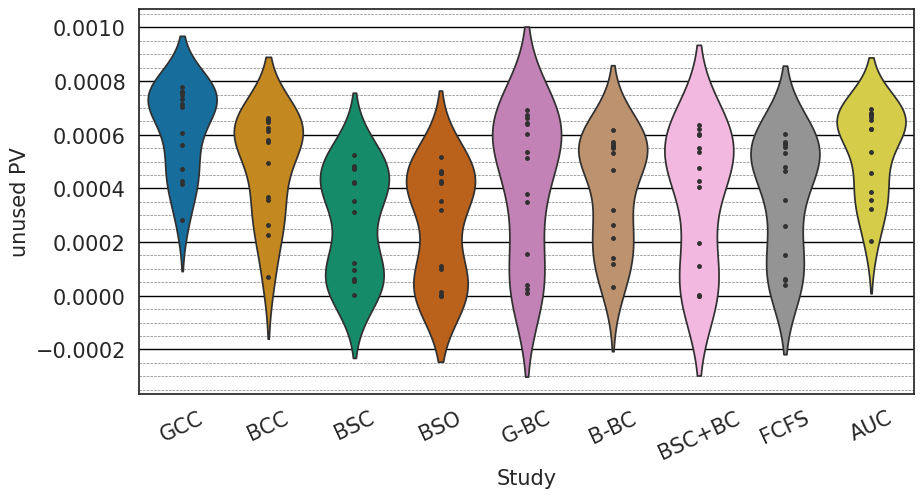

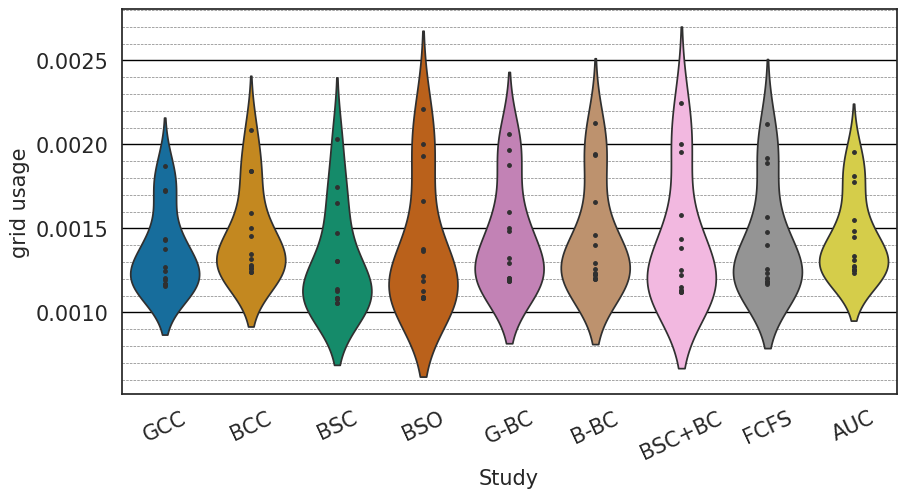

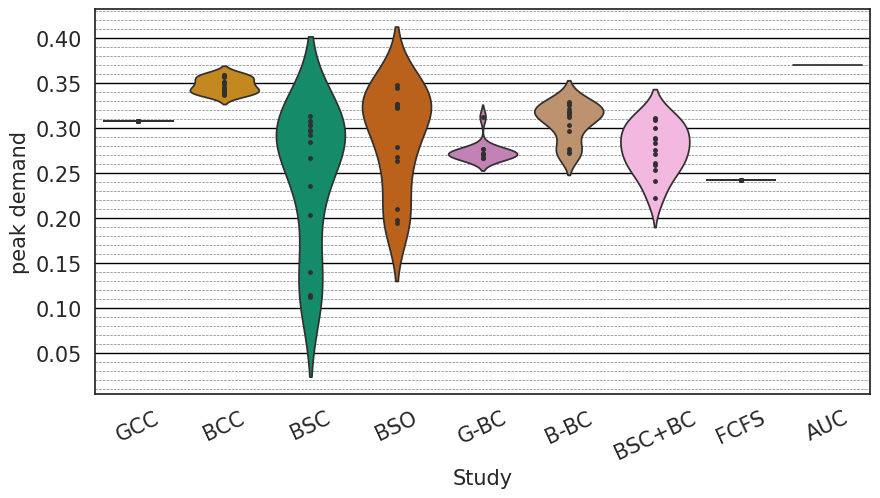

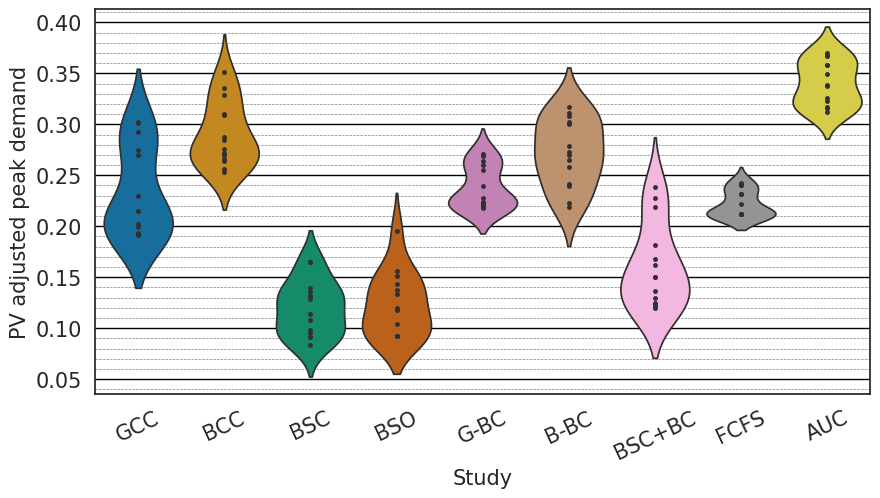

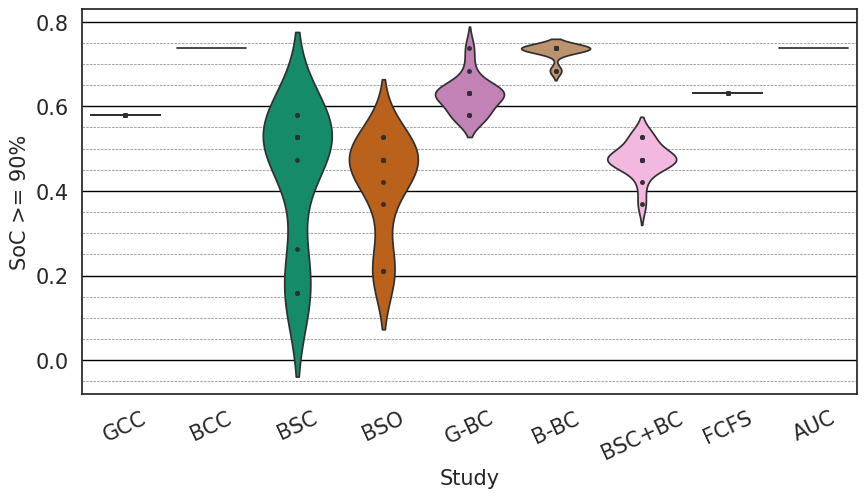

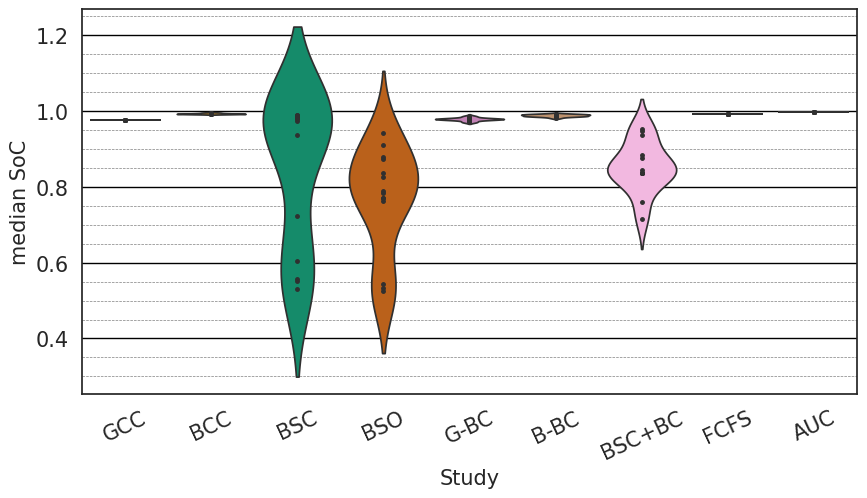

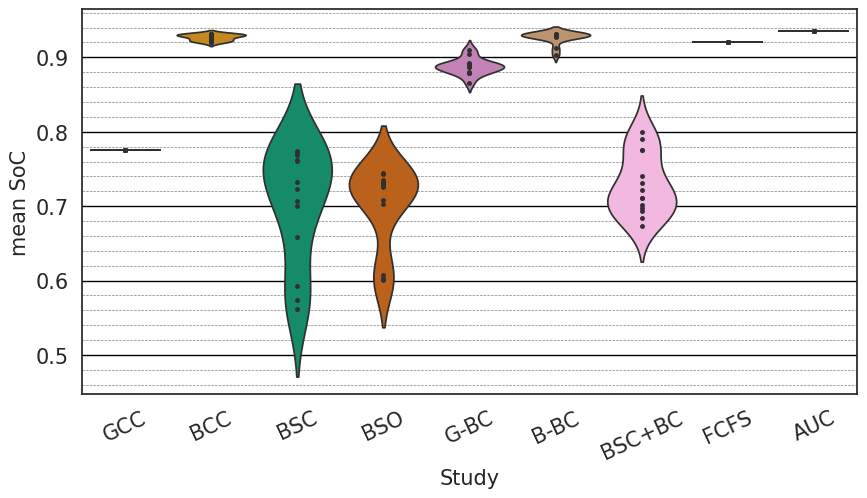

In [32]:
for metric_name, statistics in test_statistics.items():
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    df = pd.DataFrame.from_dict(statistics)
    sns.violinplot(data=df, inner="point", ax=ax)
    
    ax.set_xlabel('Study')
    ax.set_ylabel(metric_name)
    # ax.set_ylim(0, 1)
    ax.tick_params(axis='x', labelrotation=25)
    
    # Show minor grid lines on the y-axis
    ax.minorticks_on()
    ax.yaxis.grid(True, which='minor', linestyle='--', linewidth='0.5', color='black', alpha=0.5)
    ax.yaxis.grid(True, which='major', linestyle='-', linewidth='1', color='black')
    
    metric_name = metric_name.replace("%", "").replace(" ", "_")
    fig.savefig(f"{violin}/{metric_name}.pdf", dpi=300, bbox_inches = "tight")

In [ ]:
df = pd.DataFrame.from_dict(test_statistics)

for column in df.columns:
    m = np.mean(df[column].tolist(), axis=1)
    s = np.std(df[column].tolist(), axis=1)

    df[column] = [f"{m:.2g} ± {s:.2g}" for m, s in zip(m, s)]

df  # .to_latex()

### Statistic Testing

In [ ]:
from pathlib import Path

alpha_level = 0.01  # used to compare pvalues


def highlight_alpha(styler, caption: str, alpha_level: float):
    # styler.format(lambda pvalue: f"{pvalue:.3g}")
    styler.set_caption(caption)
    styler.map(
        lambda v: "font-weight: bold" if v < alpha_level else "font-weight: normal"
    )
    return styler


def format_number(v, alpha_level):
    if np.isnan(v):
        return "-"

    if isinstance(v, (int, float)):
        formatted = f"{v:.5f}"  # 4 significant digits
        return fr"$\bm{{{formatted}}}$" if v < alpha_level else fr"${formatted}$"

    return v


def to_tabularx_latex(df, filename, column_format: Optional[str] = None, caption: Optional[str] = None, label: Optional[str] = None):
    df = df.copy()
    # fix escape caracters
    df.columns = [col.replace('%', r'\%') for col in df.columns]

    # Format numeric values
    for col in df.select_dtypes(include='number').columns:
        df[col] = df[col].apply(
            lambda v: format_number(v, alpha_level=alpha_level)
        )

    # Use 'X' only for flexible text columns (usually one is enough)
    if not column_format:
        column_format = 'l' + 'r' * (len(df.columns))
    latex = df.to_latex(escape=False, index=True, column_format=column_format)

    # Replace tabular with tabularx and add textwidth
    latex = latex.replace(r'\begin{tabular}', r'\begin{tabularx}{\textwidth}')
    latex = latex.replace(r'\end{tabular}', r'\end{tabularx}')

    if caption:
        latex += rf'\caption{{{caption}}}' + "\n"

    if label:
        latex += rf"\label{{{label}}}" + "\n"

    Path(filename).write_text(latex)
    return latex

In [ ]:
# Perform normality test (Shapiro-Wilk test) https://docs.scipy.org/doc/scipy/tutorial/stats/hypothesis_shapiro.html#hypothesis-shapiro
# "The value of this statistic tends to be high (close to 1) for samples drawn from a normal distribution."
normality_results = defaultdict(lambda: {})
for metric_name, statistics in test_statistics.items():
    for model_name, values in statistics.items():
        shapiro_test = stats.shapiro(values)
        normality_results[metric_name][model_name] = shapiro_test.pvalue

df_normality = pd.DataFrame.from_dict(normality_results)
# df_normality = df_normality.style.pipe(
#     lambda s: highlight_alpha(s, "p-values for Shapiro-Wilk test", alpha_level)
# )

# df_normality.to_latex(f"{tables}/shapiro.tex")#, convert_css=False)
# df_normality

df_normality.style.pipe(
    lambda s: highlight_alpha(s, "p-values for Shapiro-Wilk test", alpha_level)
)

In [ ]:
# df_normality.to_latex(f"{tables}/shapiro.tex",convert_css=False)
caption = rf"""
    Results of the Shapiro-Wilk test for normality.
    The \textit{{p-value}} is reported for each quality metric (calculated on the evaluation dataset) and the best model from each study.
    Entries for which we reject the assumption of normality (p-value < {alpha_level}), are highlighted in bold.
""".replace("\n", "").strip()

# label = rf"""
#         tab:folder_{metric}
#         ABC
#     """.replace("%", "\%")
label = f"tab:Shapiro-Wilk-{folder}".replace("\n", "").strip()

i = to_tabularx_latex(df_normality, f"{tables}/shapiro.tex",
                      column_format="lrrrXrrr", caption=caption, label=label)
print(i)

In [ ]:
# df_normality.style.pipe(
#     lambda s: highlight_alpha(
#         s, "p-values for Shapiro-Wilk test", alpha_level)
# ).to_latex(f"{tables}/shapiro.tex",convert_css=False)

In [ ]:
import pandas as pd
from scipy import stats
from scipy.stats import mannwhitneyu


def make_t_test_plot(metric_name, test_statistics):
    # Extract statistics for the given metric
    statistics = test_statistics[metric_name]

    # Initialize an empty DataFrame to store the p-values
    model_names = list(statistics.keys())
    p_value_df = pd.DataFrame(
        index=model_names, columns=model_names, dtype=float)

    # Perform pairwise t-tests and fill in the DataFrame
    for base_model_name in model_names:
        for comparing_model_name in model_names:
            if comparing_model_name == base_model_name:
                # Assign NaN or -1 for self-comparisons
                # p_value_df.loc[base_model_name, comparing_model_name] = None  # Or you could use -1 if preferred
                pvalue = None
            else:
                # Perform t-test for pairwise models
                # t_test = stats.ttest_ind(
                #     statistics[base_model_name],
                #     statistics[comparing_model_name],
                # )
                # pvalue = t_test.pvalue

                alternative = "greater"
                if metric_name in ["unused PV", "grid usage", "peak demand", "PV adjusted peak demand"]:
                    alternative = "less"

                # Perform Mann-Whitney U test instead of t-test
                u_stat, pvalue = mannwhitneyu(
                    statistics[base_model_name],
                    statistics[comparing_model_name],
                    alternative=alternative,
                )

            p_value_df.loc[base_model_name, comparing_model_name] = pvalue

    return p_value_df


# metric = "SoC >= 90%"
for metric in test_statistics.keys():
    p_values = make_t_test_plot(metric, test_statistics)

    # The \textit{{p-value}} is reported for each pairwise test (calculated using the evaluation dataset) and the best model from each study.
    # Entries for which we reject the assumption of equal distribution (p-value < {alpha_level}), are highlighted in bold.
    # This means, that for highlighted entries we reject the hypothesis that they come from the same distribution.
    caption = rf"""
        Results of the two-sided Mann-Whitney U test for the metric \textit{{{metric}}}.
    """.replace("%", "\%").replace(r"\textit{SoC >= 90\%}", r"\textit{SoC}~$\geq$~90\%").replace("\n", "").strip()

    metric_ = metric.replace(" ", "_")

    label = rf"""
        tab:{folder}_{metric_}
    """.replace("%", "").replace("\n", "").strip()

    metric_ = metric_.replace("%", "")  # .replace(" ", "_")

    l = to_tabularx_latex(
        p_values, f"{tables}/whitney_{metric_}.tex", column_format="l" + "X" * len(list(test_statistics[metric].keys())), caption=caption, label=label)
    print(l)